<a href="https://colab.research.google.com/github/DANIEL-BONFIM/DesafioFalhaIndustrial/blob/main/Falhas_Industriais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.over_sampling import RandomOverSampler

In [ ]:
#leitura do arquivo
df=pd.read_csv('/content/desafio_manutencao_preditiva_treino.csv')

In [ ]:
#primeiras linhas
df.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,Falhas
0,298.1,308.6,1551,42.8,0,No Failure,Não Falha
1,298.2,308.7,1408,46.3,3,No Failure,Não Falha
2,298.2,308.7,1408,40.0,9,No Failure,Não Falha
3,298.1,308.6,1425,41.9,11,No Failure,Não Falha
4,298.1,308.6,1558,42.4,14,No Failure,Não Falha


In [ ]:
df

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,Falhas
0,298.1,308.6,1551,42.8,0,No Failure,Não Falha
1,298.2,308.7,1408,46.3,3,No Failure,Não Falha
2,298.2,308.7,1408,40.0,9,No Failure,Não Falha
3,298.1,308.6,1425,41.9,11,No Failure,Não Falha
4,298.1,308.6,1558,42.4,14,No Failure,Não Falha
...,...,...,...,...,...,...,...
6662,298.8,308.3,1634,27.9,12,No Failure,Não Falha
6663,298.8,308.4,1604,29.5,14,No Failure,Não Falha
6664,298.9,308.4,1632,31.8,17,No Failure,Não Falha
6665,299.0,308.7,1408,48.5,25,No Failure,Não Falha


In [ ]:
#detalhes do dataframe
df.describe()

,udi,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,4994.589921,299.992515,309.992620,1537.419529,40.058512,108.098095
std,2896.125718,1.994710,1.488101,177.182908,9.950804,63.359915
min,1.000000,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,2496.500000,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,4983.000000,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,7510.500000,301.500000,311.100000,1612.000000,46.800000,162.000000
max,10000.000000,304.500000,313.800000,2886.000000,76.600000,251.000000


In [ ]:
#contagem do tipo
df['type'].value_counts()

L    4022
M    1987
H     658
Name: type, dtype: int64

In [ ]:
#contagem das falhas
df.failure_type.value_counts()

No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

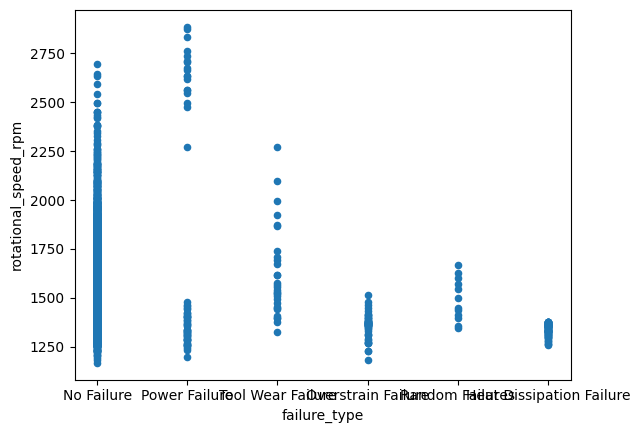

In [ ]:
#distribuição da rotação por falhas
df.plot.scatter(x='failure_type',y='rotational_speed_rpm');

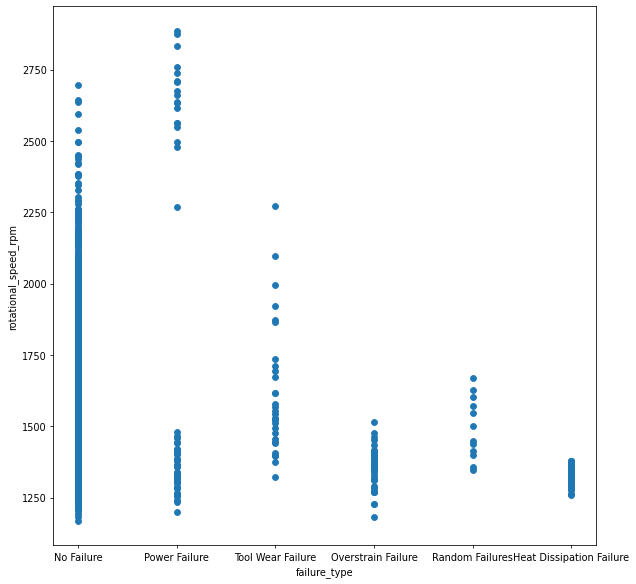

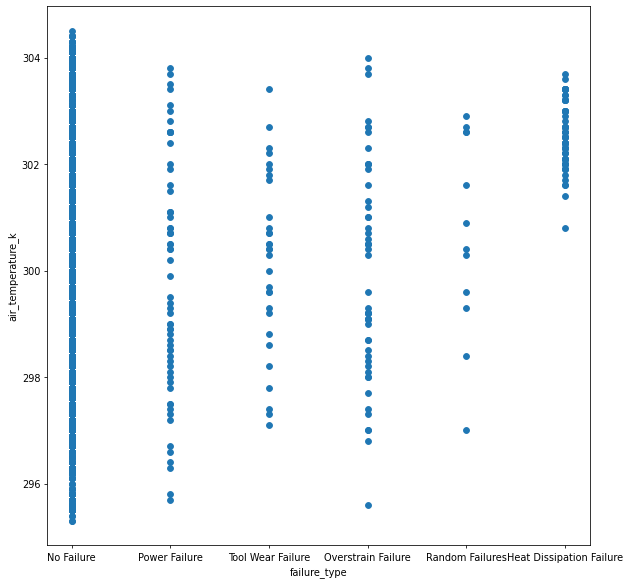

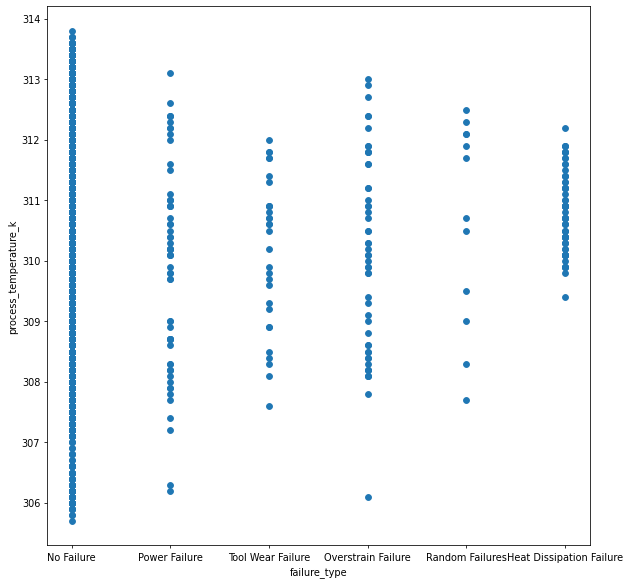

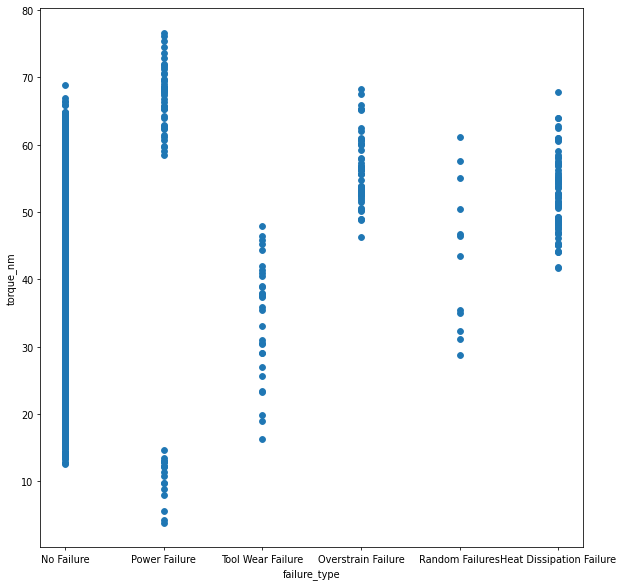

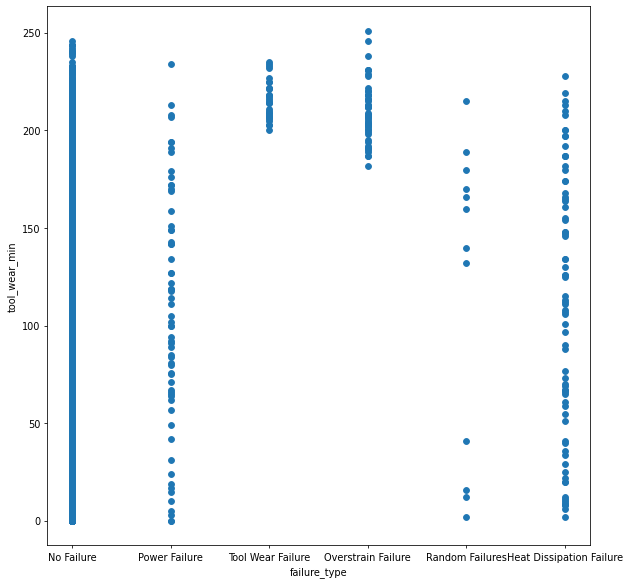

In [ ]:
#distribuição de cada campo por falhas
lista = ['rotational_speed_rpm','air_temperature_k','process_temperature_k','torque_nm','tool_wear_min']
for i in lista:
    plt.figure(figsize=(10,10), dpi=70)
    plt.scatter(x=df['failure_type'], y=df[i])
    plt.xlabel("failure_type")
    plt.ylabel(i);

<Figure size 6000x6000 with 0 Axes>

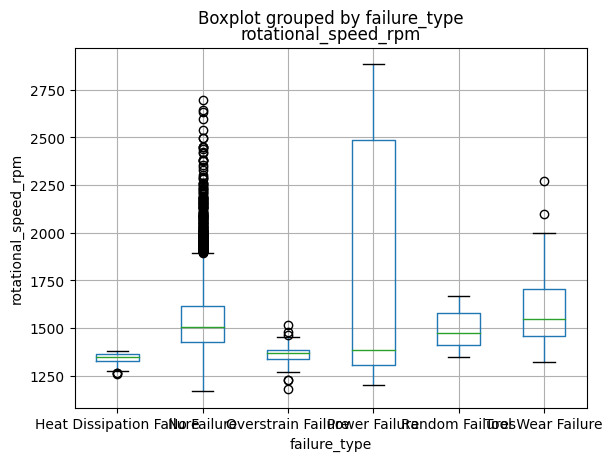

<Figure size 6000x6000 with 0 Axes>

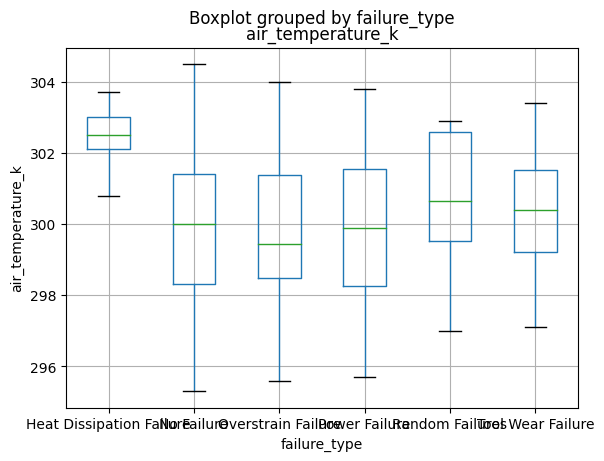

<Figure size 6000x6000 with 0 Axes>

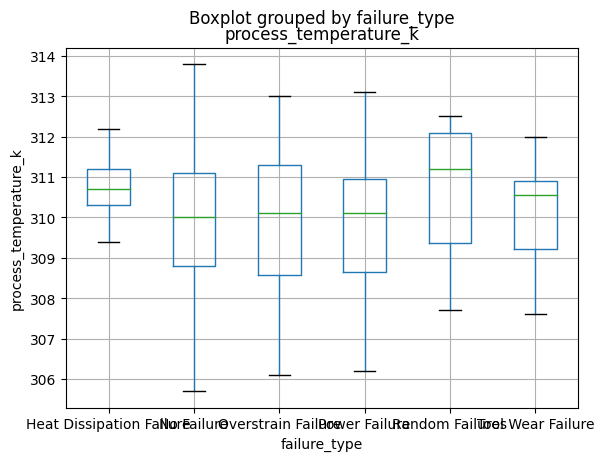

<Figure size 6000x6000 with 0 Axes>

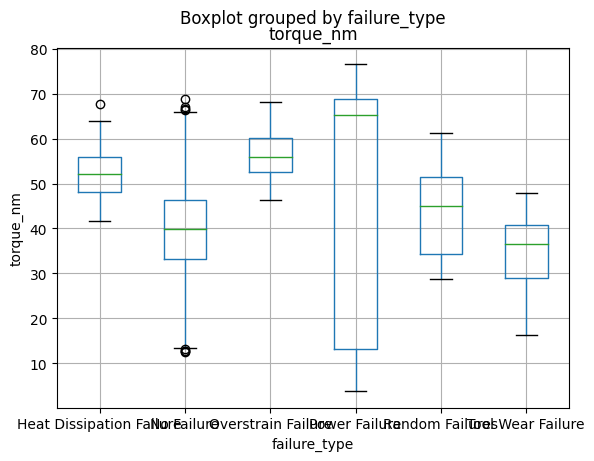

<Figure size 6000x6000 with 0 Axes>

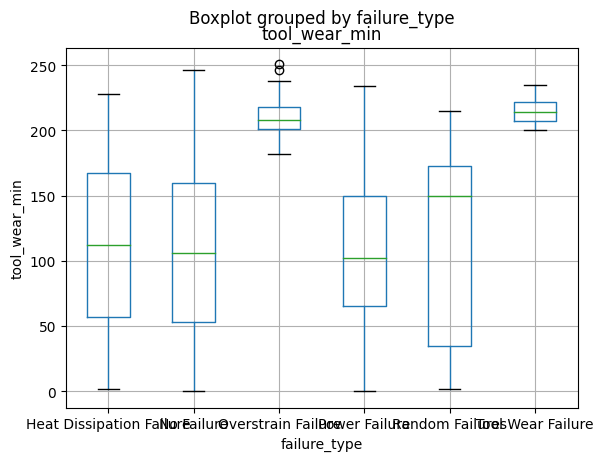

In [ ]:
#bloxpot para cada falha e campo
lista = ['rotational_speed_rpm','air_temperature_k','process_temperature_k','torque_nm','tool_wear_min']
for i in lista:
  plt.figure(figsize=(60,60), dpi=100)
  df.boxplot(column=[i],by=['failure_type'])
  plt.xlabel("failure_type")
  plt.ylabel(i);



In [ ]:
#tipos
df.dtypes

udi                        int64
product_id                object
type                      object
air_temperature_k        float64
process_temperature_k    float64
rotational_speed_rpm       int64
torque_nm                float64
tool_wear_min              int64
failure_type              object
dtype: object

In [ ]:
def eliminar_colunas(df):
  df=df.drop(columns=['udi','product_id','type'], axis=1)
  return df

df=eliminar_colunas(df)

Objetivo: prever o tipo de erro

Solução: 1º prever se falha ou não, 2º Qual a falha, caso exista falha.

In [ ]:
#Agrupar falhas (binarizar)
df['Falhas'] = ['Não Falha' if x == 'No Failure' else 'Falha' for x in df.failure_type]
y = df.Falhas
y


0       Não Falha
1       Não Falha
2       Não Falha
3       Não Falha
4       Não Falha
          ...    
6662    Não Falha
6663    Não Falha
6664    Não Falha
6665    Não Falha
6666    Não Falha
Name: Falhas, Length: 6667, dtype: object

In [ ]:
#matriz X de atributos preditores
X=df.drop(columns=['failure_type','Falhas'],axis=1)
X.describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,299.992515,309.992620,1537.419529,40.058512,108.098095
std,1.994710,1.488101,177.182908,9.950804,63.359915
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,251.000000


In [ ]:
# treino e teste stratificado(distribuido uniformemente) por y,
#ambos os conjuntos treino e teste terão o mesmo percentual de y

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2021,test_size=0.3,stratify=y)

print(y_test.value_counts(normalize='percentual'))
print(y_train.value_counts(normalize='percentual'))

Não Falha    0.965017
Falha        0.034983
Name: Falhas, dtype: float64
Não Falha    0.965281
Falha        0.034719
Name: Falhas, dtype: float64


In [ ]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


Balanceado classes e estando com KNN

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,324.000000,324.000000,324.000000,324.000000,324.000000
mean,300.494444,310.224383,1524.049383,44.704630,130.169753
std,2.053080,1.492372,286.135829,14.843977,69.357772
min,295.600000,306.100000,1181.000000,3.800000,0.000000
25%,298.900000,309.275000,1360.750000,34.375000,69.750000
50%,300.550000,310.400000,1439.000000,45.500000,142.000000
75%,302.300000,311.200000,1602.000000,55.625000,194.000000
max,304.200000,313.400000,2886.000000,76.200000,251.000000


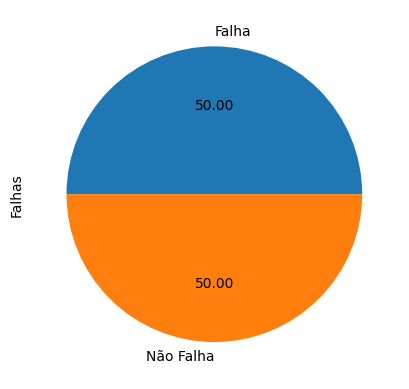

In [ ]:
#Balanceando dataset com aleatoriedade, diminuindo a classe majotiraria
rus= RandomUnderSampler(random_state=2023)
X_res, y_res = rus.fit_resample(X_train,y_train)
y_res.value_counts().plot.pie(autopct='%.2f');

X_res.describe()

In [ ]:
#Normalizando os dados
scaler = StandardScaler().fit(X_res)

X_train_norm = pd.DataFrame(scaler.transform(X_res), columns=X_res.columns)

X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [ ]:
X_test_norm.describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,-0.253710,-0.159675,0.039210,-0.304241,-0.336519
std,0.952976,0.976982,0.606877,0.658201,0.924466
min,-2.485204,-2.969250,-1.246262,-2.732912,-1.879690
25%,-1.070508,-0.888807,-0.343197,-0.749247,-1.143235
50%,-0.192420,-0.150586,-0.080679,-0.276946,-0.349018
75%,0.441754,0.520525,0.297348,0.141378,0.474079
max,1.856450,2.399635,4.725164,2.152031,1.672623


In [ ]:
#otimizando parametro
faixa_K = {'n_neighbors': np.arange(2,20)}

# Passo 2: Definir o objeto com a técnica e os parâmetros da otimização
knn_gsearch = GridSearchCV(KNeighborsClassifier(),
                           param_grid=faixa_K,
                           cv=5)

# Passo 3: Otimizar o objeto definido anteriormente no conjunto de dados
knn_gsearch.fit(X_train_norm, y_res)

# Passo 4: Apresentar o melhor K (K quando se obteve o melhor resultado)
opt_K = knn_gsearch.best_params_
print(opt_K);

##Usando matriz de confusão
from sklearn.metrics import accuracy_score, consensus_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
knn= KNeighborsClassifier(n_neighbors=opt_K['n_neighbors']).fit(X_train_norm, y_res)
y_predi = knn.predict(X_test_norm)
MatConf1= confusion_matrix(y_test,y_predi)

print('\n',MatConf1)

#imprimindo a matriz de confusão customizada
MatConf1= pd.DataFrame(confusion_matrix(y_test,y_predi,
              labels=['Não Falha','Falha']),
              index=['obs Sem Falha','obs Falha'],
              columns=['pred Sem Falha','pred Falha'])



print('\n',MatConf1)

#avaliar performance
print('\n',classification_report(y_test,y_predi))

# Imprimir acuracias
print('\n',accuracy_score(y_test,y_predi))

{'n_neighbors': 11}

 [[  58   12]
 [ 293 1638]]

                pred Sem Falha  pred Falha
obs Sem Falha            1638         293
obs Falha                  12          58

               precision    recall  f1-score   support

       Falha       0.17      0.83      0.28        70
   Não Falha       0.99      0.85      0.91      1931

    accuracy                           0.85      2001
   macro avg       0.58      0.84      0.60      2001
weighted avg       0.96      0.85      0.89      2001


 0.847576211894053


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


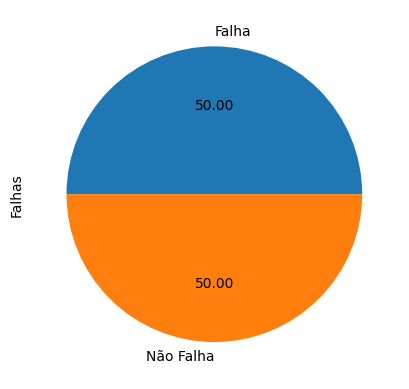

In [ ]:
#USANDO KNN PARA REBALANCEAR
rus= ClusterCentroids(random_state=2023)
X_res1, y_res1 = rus.fit_resample(X_train,y_train)
y_res1.value_counts().plot.pie(autopct='%.2f');

In [246]:
scaler1 = StandardScaler().fit(X_res1)

X_train_norm1 = pd.DataFrame(scaler1.transform(X_res1), columns=X_res1.columns)

X_test_norm1 =pd.DataFrame(scaler1.transform(X_test), columns=X_test.columns)

faixa_K = {'n_neighbors': np.arange(2,20)}

# Passo 2: Definir o objeto com a técnica e os parâmetros da otimização
knn_gsearch = GridSearchCV(KNeighborsClassifier(),
                           param_grid=faixa_K,
                           cv=5)

# Passo 3: Otimizar o objeto definido anteriormente no conjunto de dados
knn_gsearch.fit(X_train_norm1, y_res1)

# Passo 4: Apresentar o melhor K (K quando se obteve o melhor resultado)
opt_K = knn_gsearch.best_params_
print(opt_K);

from sklearn.metrics import accuracy_score, consensus_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
knn1= KNeighborsClassifier(n_neighbors=opt_K['n_neighbors']).fit(X_train_norm1, y_res1)
y_predi1 = knn1.predict(X_test_norm1)
MatConf1= confusion_matrix(y_test,y_predi1)

print('\n',MatConf1)

MatConf1= pd.DataFrame(confusion_matrix(y_test,y_predi1,
              labels=['Não Falha','Falha']),
              index=['obs Sem Falha','obs Falha'],
              columns=['pred Sem Falha','pred Falha'])



print('\n',MatConf1)


print('\n',classification_report(y_test,y_predi1))

{'n_neighbors': 2}

 [[  65    5]
 [1083  848]]

                pred Sem Falha  pred Falha
obs Sem Falha             848        1083
obs Falha                   5          65

               precision    recall  f1-score   support

       Falha       0.06      0.93      0.11        70
   Não Falha       0.99      0.44      0.61      1931

    accuracy                           0.46      2001
   macro avg       0.53      0.68      0.36      2001
weighted avg       0.96      0.46      0.59      2001



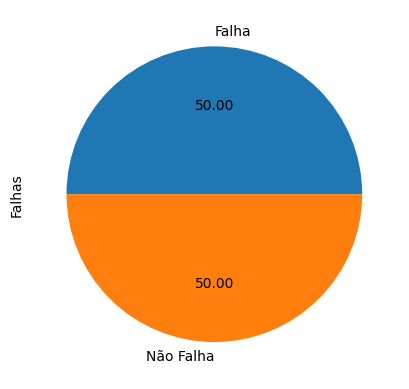

In [ ]:
#USANDO KNN PARA REBALANCEAR usando os pontos mais proximos da classe minoritaria
rus= NearMiss()
X_res3, y_res3 = rus.fit_resample(X_train,y_train)
y_res3.value_counts().plot.pie(autopct='%.2f');


In [ ]:
scaler = StandardScaler().fit(X_res3)

X_train_norm3 = pd.DataFrame(scaler.transform(X_res3), columns=X_res3.columns)

X_test_norm3 = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

faixa_K = {'n_neighbors': np.arange(2,20)}

# Passo 2: Definir o objeto com a técnica e os parâmetros da otimização
knn_gsearch = GridSearchCV(KNeighborsClassifier(),
                           param_grid=faixa_K,
                           cv=5)

# Passo 3: Otimizar o objeto definido anteriormente no conjunto de dados
knn_gsearch.fit(X_train_norm3, y_res3)

# Passo 4: Apresentar o melhor K (K quando se obteve o melhor resultado)
opt_K = knn_gsearch.best_params_
print(opt_K);

from sklearn.metrics import accuracy_score, consensus_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
knn= KNeighborsClassifier(n_neighbors=opt_K['n_neighbors']).fit(X_train_norm3, y_res3)
y_predi = knn.predict(X_test_norm3)
MatConf1= confusion_matrix(y_test,y_predi)

print('\n',MatConf1)

MatConf1= pd.DataFrame(confusion_matrix(y_test,y_predi,
              labels=['Não Falha','Falha']),
              index=['obs Sem Falha','obs Falha'],
              columns=['pred Sem Falha','pred Falha'])



print('\n',MatConf1)


print('\n',classification_report(y_test,y_predi))

{'n_neighbors': 6}

 [[  56   14]
 [ 698 1233]]

                pred Sem Falha  pred Falha
obs Sem Falha            1233         698
obs Falha                  14          56

               precision    recall  f1-score   support

       Falha       0.07      0.80      0.14        70
   Não Falha       0.99      0.64      0.78      1931

    accuracy                           0.64      2001
   macro avg       0.53      0.72      0.46      2001
weighted avg       0.96      0.64      0.75      2001



In [181]:
#Balanceando classe da melhor forma
#O parametro shrinkage serve para, a partir da classe minoritaria, criar pontos proximos dos pontos dessa classe

rus= RandomOverSampler(random_state=2023, shrinkage=1.2)
X_resOver, y_resOver = rus.fit_resample(X_train,y_train)
y_resOver.value_counts()

Não Falha    4504
Falha        4504
Name: Falhas, dtype: int64

In [182]:
y_train.describe()

count          4666
unique            2
top       Não Falha
freq           4504
Name: Falhas, dtype: object

In [183]:
scaler = StandardScaler().fit(X_resOver)

X_train_norm4 = pd.DataFrame(scaler.transform(X_resOver), columns=X_resOver.columns)

X_test_norm4 = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

faixa_K = {'n_neighbors': np.arange(4,15)}

# Passo 2: Definir o objeto com a técnica e os parâmetros da otimização
knn_gsearch = GridSearchCV(KNeighborsClassifier(),
                           param_grid=faixa_K,
                           cv=5)

# Passo 3: Otimizar o objeto definido anteriormente no conjunto de dados
knn_gsearch.fit(X_train_norm4, y_resOver)

# Passo 4: Apresentar o melhor K (K quando se obteve o melhor resultado)
opt_K = knn_gsearch.best_params_
print(opt_K);

from sklearn.metrics import accuracy_score, consensus_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

knn4= KNeighborsClassifier(n_neighbors=opt_K['n_neighbors']).fit(X_train_norm4, y_resOver)

y_predi4 = knn4.predict(X_test_norm4)
MatConf1= confusion_matrix(y_test,y_predi4)

print('\n',MatConf1)

MatConf1= pd.DataFrame(confusion_matrix(y_test,y_predi4,
              labels=['Não Falha','Falha']),
              index=['obs Não Falha','obs Falha'],
              columns=['pred Não Falha','pred Falha'])



print('\n',MatConf1)


print('\n',classification_report(y_test,y_predi4))


{'n_neighbors': 6}

 [[  55   15]
 [ 135 1796]]

                pred Não Falha  pred Falha
obs Não Falha            1796         135
obs Falha                  15          55

               precision    recall  f1-score   support

       Falha       0.29      0.79      0.42        70
   Não Falha       0.99      0.93      0.96      1931

    accuracy                           0.93      2001
   macro avg       0.64      0.86      0.69      2001
weighted avg       0.97      0.93      0.94      2001



In [166]:
#Usando XGboost e Gboost e avaliando se há melhora na predição

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

# Definir função para otimização

def ftuning(model, param, niter):
  rnd_search= RandomizedSearchCV(model,
                                 param_distributions=param,
                                 n_iter=niter,
                                 random_state=2021)
  rnd_search.fit(X_train_norm4, y_resOver)
  return rnd_search.best_params_



In [ ]:
#Otimizar parametros Gboost
faixa_param = {'n_estimators':np.arange(300,550,100),
               'learning_rate':[0.55, 0.65, 0.7, 0.8, 0.85, 0.9],
               'max_depth':np.arange(3,11,2)}

n_iter = 15

opt_params = ftuning(GradientBoostingClassifier(), faixa_param, n_iter)
print('GBoost opt_params:', opt_params)
# Passo 2: Definir o objeto com a técnica e os parâmetros da otimização

print('GBoost opt_params:', opt_params)

GBoost opt_params: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.8}
GBoost opt_params: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.8}


In [184]:
gboost_clf = GradientBoostingClassifier(n_estimators=opt_params['n_estimators'],
                                        learning_rate=opt_params['learning_rate'],
                                        max_depth=opt_params['max_depth']).fit(X_train_norm4, y_resOver)

# Fazer predição no conjunto de teste
y_pred_gboost = gboost_clf.predict(X_test_norm4)


# Apresentar Matriz de Confusão
print('Matriz de Confusão - Gradient Boosting')
print(pd.crosstab(y_test,y_pred_gboost, rownames=['Obs'],colnames=['Pred'], margins=True))

# Apresentar Relatório Geral do Modelo (classification_report)
print(classification_report(y_test, y_pred_gboost))

Matriz de Confusão - Gradient Boosting
Pred       Falha  Não Falha   All
Obs                              
Falha         39         31    70
Não Falha     23       1908  1931
All           62       1939  2001
              precision    recall  f1-score   support

       Falha       0.63      0.56      0.59        70
   Não Falha       0.98      0.99      0.99      1931

    accuracy                           0.97      2001
   macro avg       0.81      0.77      0.79      2001
weighted avg       0.97      0.97      0.97      2001



In [245]:
#otimização xgboost
from sklearn.preprocessing import LabelEncoder

classifier = xgb.XGBClassifier()

faixa_param = {'n_estimators':np.arange(100,401,50),
               'learning_rate':[0.55, 0.65, 0.7, 0.8, 0.85, 0.9],
               'max_depth':np.arange(1,8,2)}

n_iter = 15
y_resOver_encoded = LabelEncoder().fit_transform(y_resOver)
y_test_enc=LabelEncoder().fit_transform(y_test)

opt_params2 = RandomizedSearchCV(classifier,param_distributions=faixa_param,n_iter=n_iter,error_score='raise').fit(X_train_norm4, y_resOver_encoded).best_params_

print('XGBoost opt_params:', opt_params2)

XGBoost opt_params: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.7}


In [169]:
xgb_clf = xgb.XGBClassifier(n_estimators=opt_params['n_estimators'],
                            learning_rate=opt_params['learning_rate'],
                            max_depth=opt_params['max_depth']).fit(X_train_norm4, y_resOver_encoded)

# Fazer predição no conjunto de teste
y_pred_xgb = xgb_clf.predict(X_test_norm4)


# Apresentar Matriz de Confusão
print('Matriz de Confusão - XGB (eXtreme Gradient Boosting')
print(pd.crosstab(y_test_enc,y_pred_xgb, rownames=['Obs'],colnames=['Pred'], margins=True))

# Apresentar Relatório Geral do Modelo (classification_report)
print(classification_report(y_test_enc, y_pred_xgb))

Matriz de Confusão - XGB (eXtreme Gradient Boosting
Pred    0     1   All
Obs                  
0      51    19    70
1      87  1844  1931
All   138  1863  2001
              precision    recall  f1-score   support

           0       0.37      0.73      0.49        70
           1       0.99      0.95      0.97      1931

    accuracy                           0.95      2001
   macro avg       0.68      0.84      0.73      2001
weighted avg       0.97      0.95      0.96      2001



In [ ]:
#GBOOST APRESENTOU O MELHOR RESULTADO, COM ISSO, TESTAREMOS O MODELO COM NOVOS DADOS

air=298
process=325
rota =1551
torque=45
tool =0



novos_dados=[air,process,rota,torque,tool]
novos_dados=np.array(novos_dados).reshape(1,-1)
novos_dados=pd.DataFrame(novos_dados,columns=['air_temperature_k','process_temperature_k','rotational_speed_rpm','torque_nm','tool_wear_min'])
novos_dados=scaler.transform(novos_dados)

print('O equipamento:', gboost_clf.predict(novos_dados))


O equipamento: ['Falha']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Trabalhando com predição do tipo de Falha

In [ ]:
dffalhas=df[df['failure_type']!='No Failure']
dffalhas

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,Falhas
52,298.9,309.0,1410,65.7,191,Power Failure,Falha
56,298.8,308.9,1455,41.3,208,Tool Wear Failure,Falha
112,298.4,308.2,1282,60.7,216,Overstrain Failure,Falha
113,298.3,308.1,1412,52.3,218,Overstrain Failure,Falha
143,298.4,308.7,1421,60.7,119,Power Failure,Falha
...,...,...,...,...,...,...,...
6440,299.1,310.2,1317,54.8,231,Overstrain Failure,Falha
6442,299.2,310.3,1352,48.9,238,Overstrain Failure,Falha
6501,298.6,309.8,2271,16.2,218,Tool Wear Failure,Falha
6537,298.5,309.4,1360,60.9,187,Overstrain Failure,Falha


In [ ]:
X_falhas = dffalhas.drop(columns=['failure_type','Falhas'],axis=1)
y_falhas = dffalhas.failure_type
y_falhas.value_counts()

Heat Dissipation Failure    75
Power Failure               63
Overstrain Failure          52
Tool Wear Failure           30
Random Failures             12
Name: failure_type, dtype: int64

In [ ]:
X_falhas

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
52,298.9,309.0,1410,65.7,191
56,298.8,308.9,1455,41.3,208
112,298.4,308.2,1282,60.7,216
113,298.3,308.1,1412,52.3,218
143,298.4,308.7,1421,60.7,119
...,...,...,...,...,...
6440,299.1,310.2,1317,54.8,231
6442,299.2,310.3,1352,48.9,238
6501,298.6,309.8,2271,16.2,218
6537,298.5,309.4,1360,60.9,187


In [ ]:
X_train_falhas, X_test_falhas, y_train_falhas, y_test_falhas = train_test_split(X_falhas,y_falhas, random_state=2021,test_size=0.3,stratify=y_falhas)

In [ ]:
def ftuningfalhas(model, param, niter):
  rnd_search= RandomizedSearchCV(model,
                                 param_distributions=param,
                                 n_iter=niter,
                                 random_state=2021)
  rnd_search.fit(X_train_norm2, y_resOver2)
  return rnd_search.best_params_

In [170]:
rus= RandomOverSampler(random_state=2023, shrinkage=1.05)
X_resOver2, y_resOver2 = rus.fit_resample(X_falhas,y_falhas)

scaler2 = StandardScaler().fit(X_resOver2)

X_train_norm2 = pd.DataFrame(scaler2.transform(X_resOver2), columns=X_resOver2.columns)

X_test_norm2 = pd.DataFrame(scaler2.transform(X_test_falhas), columns=X_test_falhas.columns)

faixa_param = {'n_estimators':np.arange(250,550,50),
               'learning_rate':[0.55, 0.65, 0.7, 0.8, 0.85, 0.9],
               'max_depth':np.arange(3,11,2)}

n_iter = 15

opt_params = ftuningfalhas(GradientBoostingClassifier(), faixa_param, n_iter)
print('GBoost opt_params:', opt_params)
# Passo 2: Definir o objeto com a técnica e os parâmetros da otimização

print('GBoost opt_params:', opt_params)

GBoost opt_params: {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.7}
GBoost opt_params: {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.7}


In [171]:
gboost_clf2 = GradientBoostingClassifier(n_estimators=opt_params['n_estimators'],
                                        learning_rate=opt_params['learning_rate'],
                                        max_depth=opt_params['max_depth']).fit(X_train_norm2, y_resOver2)

# Fazer predição no conjunto de teste
y_pred_gboost2 = gboost_clf2.predict(X_test_norm2)

# Avaliar o modelo
# Acurácia, Precisão, Recall e F1-Score


# Apresentar Matriz de Confusão
print('Matriz de Confusão - Gradient Boosting')
print(pd.crosstab(y_test_falhas,y_pred_gboost2, rownames=['Obs'],colnames=['Pred'], margins=True))

# Apresentar Relatório Geral do Modelo (classification_report)
print(classification_report(y_test_falhas, y_pred_gboost2))

Matriz de Confusão - Gradient Boosting
Pred                      Heat Dissipation Failure  Overstrain Failure  \
Obs                                                                      
Heat Dissipation Failure                        23                   0   
Overstrain Failure                               0                  16   
Power Failure                                    0                   0   
Random Failures                                  0                   0   
Tool Wear Failure                                0                   0   
All                                             23                  16   

Pred                      Power Failure  Random Failures  Tool Wear Failure  \
Obs                                                                           
Heat Dissipation Failure              0                0                  0   
Overstrain Failure                    0                0                  0   
Power Failure                        19             

In [178]:
#TESTANDO
air=302.4
process=311.1
rota =1366
torque=54.4
tool =0



novos_dados=[air,process,rota,torque,tool]
novos_dados=np.array(novos_dados).reshape(1,-1)
novos_dados=pd.DataFrame(novos_dados,columns=['air_temperature_k','process_temperature_k','rotational_speed_rpm','torque_nm','tool_wear_min'])
novos_dados=scaler.transform(novos_dados)

if gboost_clf.predict(novos_dados)=='Falha':
  print('O equipamento falha, e a falha é: ', gboost_clf2.predict(novos_dados));
else:
  print('O equipamento não Falha')

O equipamento não Falha


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [232]:
final=pd.read_csv('/content/desafio_manutencao_preditiva_teste.csv')
final=eliminar_colunas(final)

In [233]:
final = pd.DataFrame(scaler.transform(final), columns=final.columns)
final

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,-1.332401,-0.985308,0.919457,-1.203255,-0.799364
1,0.155252,0.247860,0.072971,0.142826,0.880639
2,-1.471868,-1.115115,-0.177351,-0.201822,-1.198709
3,-0.449107,-0.660790,0.514329,-0.604996,-0.826905
4,1.735884,1.935354,0.119083,-0.930137,-1.639365
...,...,...,...,...,...
3328,0.992057,1.156511,-0.684583,0.942672,0.605228
3329,0.155252,0.572378,-0.332156,0.441955,-0.510183
3330,0.201741,0.702185,-0.108183,-0.435924,0.729163
3331,1.131525,1.351221,-0.015959,-0.565980,-1.047233


In [234]:
final['predicao']=pd.Series(data=gboost_clf.predict(final))
final['falha']=pd.Series(data=gboost_clf2.predict(final.drop(columns=['predicao'],axis=1)))

In [235]:
final

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,predicao,falha
0,-1.332401,-0.985308,0.919457,-1.203255,-0.799364,Não Falha,Random Failures
1,0.155252,0.247860,0.072971,0.142826,0.880639,Não Falha,Overstrain Failure
2,-1.471868,-1.115115,-0.177351,-0.201822,-1.198709,Não Falha,Random Failures
3,-0.449107,-0.660790,0.514329,-0.604996,-0.826905,Não Falha,Random Failures
4,1.735884,1.935354,0.119083,-0.930137,-1.639365,Não Falha,Random Failures
...,...,...,...,...,...,...,...
3328,0.992057,1.156511,-0.684583,0.942672,0.605228,Não Falha,Overstrain Failure
3329,0.155252,0.572378,-0.332156,0.441955,-0.510183,Não Falha,Random Failures
3330,0.201741,0.702185,-0.108183,-0.435924,0.729163,Não Falha,Tool Wear Failure
3331,1.131525,1.351221,-0.015959,-0.565980,-1.047233,Não Falha,Random Failures


In [239]:
final['resultado']= final.apply(lambda row: row['falha'] if row['predicao']=='Falha' else 'Não Falha',axis=1)

In [ ]:
final=final.drop(columns=['predicao','falha'])


In [244]:
final

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,resultado
0,-1.332401,-0.985308,0.919457,-1.203255,-0.799364,Não Falha
1,0.155252,0.247860,0.072971,0.142826,0.880639,Não Falha
2,-1.471868,-1.115115,-0.177351,-0.201822,-1.198709,Não Falha
3,-0.449107,-0.660790,0.514329,-0.604996,-0.826905,Não Falha
4,1.735884,1.935354,0.119083,-0.930137,-1.639365,Não Falha
...,...,...,...,...,...,...
3328,0.992057,1.156511,-0.684583,0.942672,0.605228,Não Falha
3329,0.155252,0.572378,-0.332156,0.441955,-0.510183,Não Falha
3330,0.201741,0.702185,-0.108183,-0.435924,0.729163,Não Falha
3331,1.131525,1.351221,-0.015959,-0.565980,-1.047233,Não Falha
